# Lesson 2 : LangGraph Components

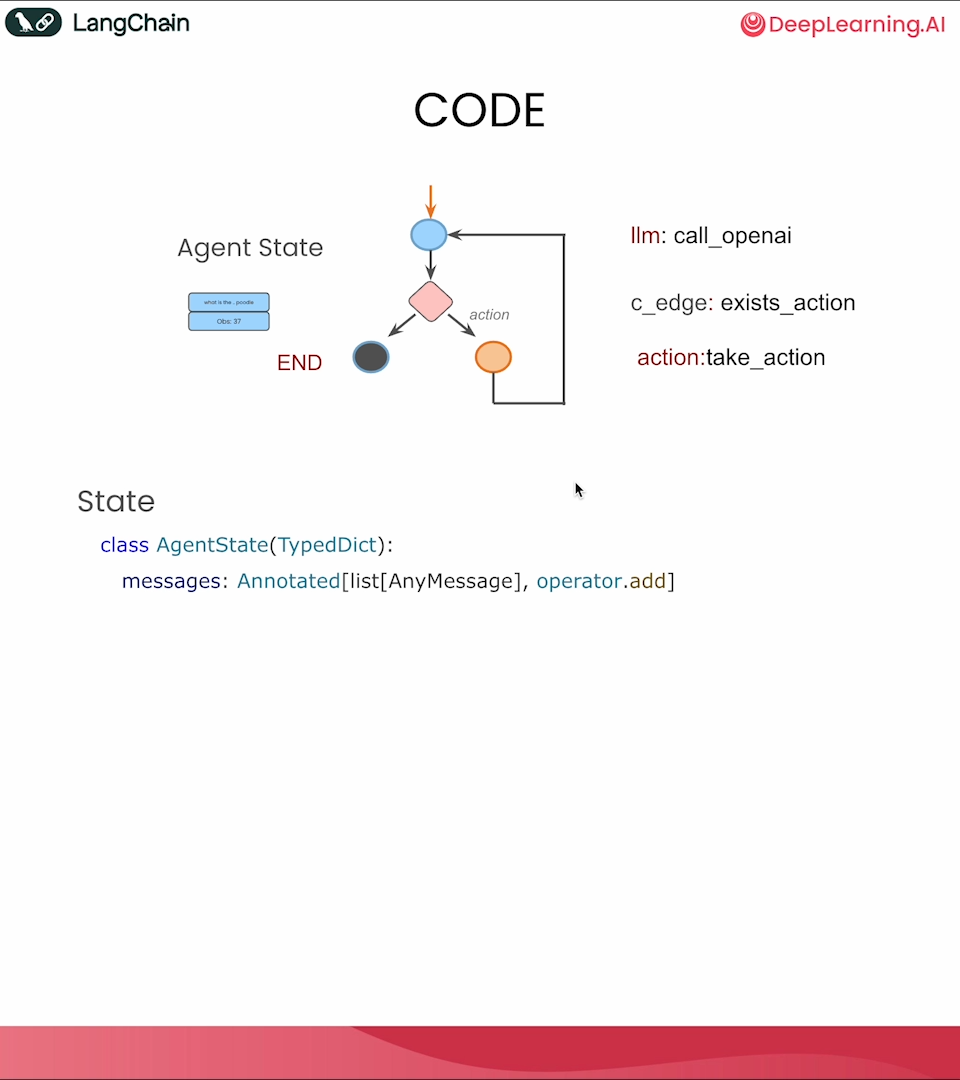

In [1]:
from dotenv import load_dotenv
_ = load_dotenv()

In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

In [3]:
tool = TavilySearchResults(max_results=4) #increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


> If you are not familiar with python typing annotation, you can refer to the [python documents](https://docs.python.org/3/library/typing.html).

In [6]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

> Note: in `take_action` below, some logic was added to cover the case that the LLM returned a non-existent tool name. Even with function calling, LLMs can still occasionally hallucinate. Note that all that is done is instructing the LLM to try again! An advantage of an agentic organization.

In [7]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile() # turn this into a langchain runnable which exposes standard interface for calling/invoking this graph  
        self.tools = {t.name: t for t in tools} # Mapping the name of the tool to tool itself
        self.model = model.bind_tools(tools) # passing in the list of tools, letting the model know it has these tools available

    def exists_action(self, state: AgentState): # Adding node as function 
        result = state['messages'][-1] # condiitonal edge turns a boolean on if we should take an action or not. 
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState): # Adding node as function 
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState): # Adding node as function 
        tool_calls = state['messages'][-1].tool_calls # this attribute `tool_calls` is returned from LLM message, some modern models would have parallel tool call whihc is a list of tools will be returned   
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [8]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model="gpt-3.5-turbo")  #reduce inference cost
abot = Agent(model, [tool], system=prompt)

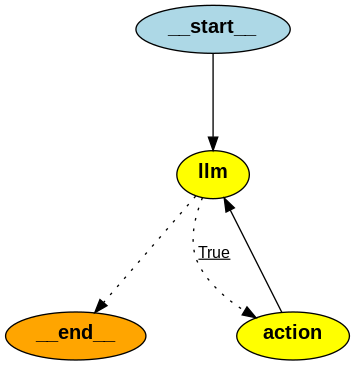

In [9]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [10]:
messages = [HumanMessage(content="What is the weather in sf?")] 
# We have to pass it as HumanMessage object 
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_PvPN1v7bHUxOdyn4J2xJhYOX'}
Back to the model!


In [11]:
result

{'messages': [HumanMessage(content='What is the weather in sf?'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_PvPN1v7bHUxOdyn4J2xJhYOX', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 153, 'total_tokens': 174, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-e4740572-9d98-4c32-9ea2-8a813b36a09f-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_PvPN1v7bHUxOdyn4J2xJhYOX'}]),
  ToolMessage(content='[{\'url\': \'https://weathershogun.com/weather/usa/ca/san-francisco/480/june/2

In [12]:
result['messages'][-1].content

'The weather in San Francisco today is as follows:\n\n- Day: 64°F\n- Night: 52°F\n- Precipitation: 0%\n- Wind: 12 mph\n- UV Index: 10\n\nFor more detailed information, you can visit [WeatherShogun](https://weathershogun.com/weather/usa/ca/san-francisco/480/june/2025-06-14).'

In [13]:
messages = [HumanMessage(content="What is the weather in SF and LA?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_1SqGYuEtOOFN1yiIHSQTPnvE'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_8RiM72Y7G8V7c3HEEAML1SKP'}
Back to the model!


In [14]:
result['messages'][-1].content

'The weather in San Francisco on Saturday, June 14, 2025, is expected to have a daytime temperature of 64°F and a nighttime temperature of 52°F with a 0% chance of precipitation and winds at 12 mph. The UV Index is high at 10.\n\nIn Los Angeles in June 2025, the average temperature is around 62°F to 80°F with no rainy days on average. The weather in Los Angeles during June is described as perfect.'

In [15]:
# Note, the query was modified to produce more consistent results. 
# Results may vary per run and over time as search information and models change.

query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question." 
messages = [HumanMessage(content=query)]

model = ChatOpenAI(model="gpt-4o")  # requires more advanced model
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': '2024 Super Bowl winner'}, 'id': 'call_HBUU1Lo9WSgKCPKYCAStSb7g'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Kansas City Chiefs headquarters state'}, 'id': 'call_RUBGBZjSi7Il7J9noht3YFfV'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'GDP of Missouri'}, 'id': 'call_hGzNLu0s8DEw3qS54v2RHPhU'}
Back to the model!


In [16]:
print(result['messages'][-1].content)

1. The Kansas City Chiefs won the Super Bowl in 2024.
2. The headquarters of the Kansas City Chiefs is located in Missouri.
3. The GDP of Missouri in 2023 was approximately $348.49 billion in inflation-adjusted dollars.
